<a href="https://colab.research.google.com/github/Mike030668/MIPT_magistratura/blob/main/CV_Gan/gan_hw_cond_conv.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### WGAN

* Модифицируйте код ячеек ниже и реализуйте [Wasserstein GAN](https://arxiv.org/abs/1701.07875) с клиппингом весов. (10 баллов)

* Замените клиппинг весов на [штраф градентов](https://arxiv.org/pdf/1704.00028v3.pdf). (10 баллов)

* Добавьте лейблы в WGAN, тем самым решая задачу [условной генерации](https://arxiv.org/pdf/1411.1784.pdf). (30 баллов)

Добавьте в этот файл анализ полученных результатов с различными графиками обучения и визуализацию генерации. Сравните как работает клиппинг весов и штраф градиентов и попробуйте пронаблюдать какие недостатки имеет модель GAN.

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset

import torchvision
import matplotlib.pyplot as plt
import numpy as np

from torch.autograd import Variable

### Простой конфиг (для хранения параметров, можете использовать и модифицировать)

In [ ]:
IMG_ROWS,IMG_COLS = 28, 28

class Config:
    pass

config = Config()
config.mnist_path = None
config.batch_size = 16
config.num_workers = 3
config.num_epochs = 15
config.noise_size = IMG_ROWS*IMG_COLS
config.print_freq = 500
config.latent_dims = 36
config.capacity = 64
config.n_critic = 5

### Создаем dataloader

In [ ]:
img_transform = torchvision.transforms.Compose([
    torchvision.transforms.ColorJitter(brightness=.1, contrast=.1),
    torchvision.transforms.ToTensor(),
    #torchvision.transforms.Normalize((0.5,), (0.5,))
])


train = torchvision.datasets.FashionMNIST("fashion_mnist",
                                          train=True,
                                          transform=img_transform,
                                          download=True)

In [ ]:
dataloader = DataLoader(train, batch_size=16, shuffle=True)
len(dataloader)

3750

In [ ]:
image, label = next(iter(dataloader))
image.size(), label

(torch.Size([16, 1, 28, 28]),
 tensor([8, 0, 6, 2, 4, 7, 6, 9, 5, 8, 7, 0, 1, 6, 6, 6]))

### Создаем модель GAN

#### Generator with CONV encoder




In [ ]:
class Encoder(nn.Module):
    def __init__(self):
        super(Encoder, self).__init__()
        c = config.capacity
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=c, kernel_size=4, stride=2, padding=1) # out: c x 14 x 14
        self.conv2 = nn.Conv2d(in_channels=c, out_channels=c*2, kernel_size=4, stride=2, padding=1) # out: c x 7 x 7
        self.fc = nn.Linear(in_features=c*2*7*7, out_features=config.latent_dims)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = x.view(x.size(0), -1) # flatten batch of multi-channel feature maps to a batch of feature vectors
        x = self.fc(x)
        return x

class Decoder(nn.Module):
    def __init__(self, nun_classes, embedding_dim):
        super(Decoder, self).__init__()
        c = config.capacity
        self.embedding = nn.Embedding(nun_classes, embedding_dim)
        self.fc = nn.Linear(in_features=config.latent_dims+embedding_dim, out_features=c*2*7*7)
        self.conv2 = nn.ConvTranspose2d(in_channels=c*2, out_channels=c, kernel_size=4, stride=2, padding=1)
        self.conv1 = nn.ConvTranspose2d(in_channels=c, out_channels=1, kernel_size=4, stride=2, padding=1)
        self.conv = nn.Conv2d(in_channels=1, out_channels=1, kernel_size=1)

    def forward(self, input, label):
        #print('decoder_input', input.shape)
        #embed label
        label = self.embedding(label)
        #print('label', label.shape)
        #concatenate image vector and label
        to_decode = torch.cat([input, label], 1)
        #print('to_decode', to_decode.shape)
        x = self.fc(to_decode)
        #print('x', x.shape)
        x = x.view(x.size(0), config.capacity*2, 7, 7) # unflatten batch of feature vectors to a batch of multi-channel feature maps
        #print('x', x.shape)
        x = F.relu(self.conv2(x))
        #print('x', x.shape)
        x = self.conv1(x)
        x = self.conv(x)
        #print('x', x.shape)
        return x

class Generator(nn.Module):
    def __init__(self, nun_classes, embedding_dim):
        super(Generator, self).__init__()
        self.encoder = Encoder()
        self.decoder = Decoder(nun_classes, embedding_dim)

    def forward(self, input, label):
        #print('ecoder_input', input.shape)
        latent = self.encoder(input)
        #print('latent', latent.shape)
        x_recon = self.decoder(latent, label)
        return x_recon


#### Discriminator




In [ ]:
class Discriminator(nn.Module):
    def __init__(self, nun_classes, embedding_dim):
        super(Discriminator, self).__init__()
        self.embedding = nn.Embedding(nun_classes, embedding_dim)

        self.model = nn.Sequential(
            nn.Linear(IMG_ROWS*IMG_COLS + embedding_dim, 256),
            nn.ReLU(inplace=True),
            nn.Linear(256, 128),
            nn.ReLU(inplace=True),
            nn.Linear(128, 1),
           # nn.Sigmoid()
            )
    def forward(self, x, label):
        #embed label
        label = self.embedding(label)

        #concatenate image vector and label
        input = torch.cat([x, label], 1)

        return self.model(input)

In [ ]:
NUM_CLASSES = len(set(train.targets.numpy()) )
EMB_DIM = 8

generator = Generator(NUM_CLASSES, EMB_DIM)
discriminator = Discriminator(NUM_CLASSES, EMB_DIM)

num_params = sum(p.numel() for p in generator.parameters() if p.requires_grad)
print('Number of parameters generator: %d' % num_params)

num_params = sum(p.numel() for p in discriminator.parameters() if p.requires_grad)
print('Number of parameters discriminator: %d' % num_params)

Number of parameters generator: 772599
Number of parameters discriminator: 236113


### Оптимизатор и функция потерь

In [ ]:
DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'
generator = generator.to(DEVICE)
discriminator = discriminator.to(DEVICE)
optim_G = optim.Adam(params=generator.parameters(), lr=0.001)
optim_D = optim.Adam(params=discriminator.parameters(), lr=0.001)

#criterion = nn.BCELoss()
criterion = nn.BCEWithLogitsLoss()

In [ ]:
lr = 0.001
for i in range(15):
  lr *= 0.95**i
  print(lr)

0.001
0.00095
0.000857375
0.0007350918906249999
0.0005987369392383787
0.0004632912301597531
0.0003405616262881148
0.00023782688525533218
0.0001577792147882268
9.944025698709225e-05
5.953855510552941e-05
3.386553563803221e-05
1.8299583806109228e-05
9.393946474176e-06
4.581192650606183e-06


### Для оптимизации процесса обучения можно заранее определить переменные и заполнять их значения новыми данными

In [ ]:
fixed_noise = torch.concat([torch.randn(1, 1, IMG_ROWS,IMG_COLS) for _ in range(config.batch_size)], axis = 0).to(DEVICE)
fixed_classes = torch.randint(0, NUM_CLASSES, (config.batch_size,))
label = Variable(torch.FloatTensor(config.batch_size).to(DEVICE))
real_label = 1
fake_label = 0

### Plot condition generation

In [ ]:
# Create a dictionary for each type of label
dict_labels = {0 : "T-shirt/top", 1: "Trouser", 2: "Pullover", 3: "Dress", 4: "Coat",
          5: "Sandal", 6: "Shirt", 7: "Sneaker", 8: "Bag", 9: "Ankle Boot"}

def plot_gen_images(gen_tensor, labels, cmap="Blues"):
    # Plot the sample images now
    f, ax = plt.subplots(4,4, figsize=(9,9))
    for i in range(gen_tensor.shape[0]):
        gen_img = gen_tensor[i].detach().cpu().numpy()
        data_min = np.min(gen_img, axis=(1,2), keepdims=True)
        data_max = np.max(gen_img, axis=(1,2), keepdims=True)
        scaled_data = (gen_img - data_min) / (data_max - data_min)

        ax[i//4, i%4].imshow(scaled_data.reshape(IMG_ROWS,IMG_COLS), cmap=cmap)
        ax[i//4, i%4].axis('off')
        ax[i//4, i%4].set_title("Gen:{}".format(dict_labels[labels[i].item()]))
    plt.show()

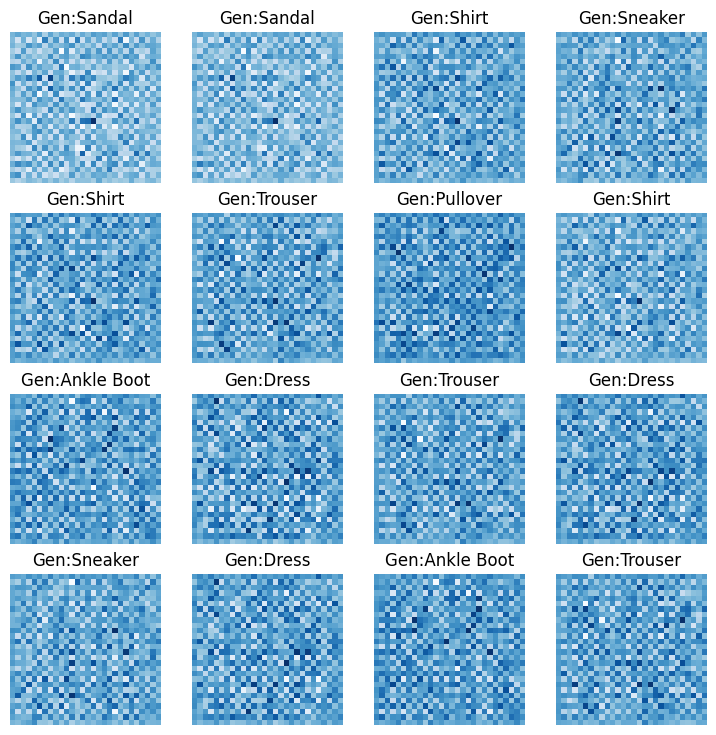

In [ ]:
gen_images = generator(fixed_noise, fixed_classes.to(DEVICE))
plot_gen_images(gen_images, fixed_classes)

In [ ]:
discriminator(gen_images.view(gen_images.shape[0], -1),  fixed_classes.to(DEVICE)).view(-1)

tensor([-0.0111, -0.0107,  0.0044, -0.0130,  0.0052, -0.0173,  0.0177,  0.0042,
        -0.0121, -0.0126, -0.0190, -0.0078, -0.0143, -0.0122, -0.0081, -0.0176],
       device='cuda:0', grad_fn=<ViewBackward0>)

### GAN обучение

In [ ]:
from torch import autograd

def compute_gradient_penalty(critic, real_samples, fake_samples, label):
    Tensor = torch.cuda.FloatTensor

    """Calculates the gradient penalty loss for WGAN GP"""

    real_samples = real_samples.view(gen_images.shape[0], -1)
    fake_samples = fake_samples.view(gen_images.shape[0], -1)
    # Random weight term for interpolation between real and fake samples
    alpha = torch.rand(real_samples.size(0), 1).to(DEVICE)

    # Get random interpolation between real and fake samples
    interpolates = (alpha * real_samples + ((1 - alpha) * fake_samples)).requires_grad_(True)
    d_interpolates = critic(interpolates, label)
    #fake = Variable(Tensor(real_samples.shape[0], 1).fill_(1.0), requires_grad=False)
    fake = Variable(torch.rand(real_samples.size(0), 1), requires_grad=False).to(DEVICE)

    # Get gradient w.r.t. interpolates
    gradients = autograd.grad(
        outputs=d_interpolates,
        inputs=interpolates,
        grad_outputs=fake,
        create_graph=True,
        retain_graph=True,
        only_inputs=True,
    )[0]
    gradients = gradients.view(gradients.size(0), -1)
    gradient_penalty = ((gradients.norm(2, dim=1)) ** 2 -1).mean()
    return gradient_penalty

Epoch:1 Iter: 500 ERRD_x: 0.0005 ERRD_z: 0.0001 g_penalty: 0.5790 errG: 0.8826 lr_D: 0.001000000 lr_G: 0.001000000
Epoch:1 Iter: 1000 ERRD_x: 0.0002 ERRD_z: 0.0002 g_penalty: 1.3233 errG: 0.5558 lr_D: 0.001000000 lr_G: 0.001000000
Epoch:1 Iter: 1500 ERRD_x: 0.0001 ERRD_z: 0.0001 g_penalty: 1.4025 errG: 0.5119 lr_D: 0.000995012 lr_G: 0.000999000
Epoch:1 Iter: 2000 ERRD_x: 0.0008 ERRD_z: 0.0004 g_penalty: 3.4853 errG: 0.5360 lr_D: 0.000990050 lr_G: 0.000998002
Epoch:1 Iter: 2500 ERRD_x: 0.0002 ERRD_z: 0.0002 g_penalty: 2.6707 errG: 0.4689 lr_D: 0.000980199 lr_G: 0.000996008
Epoch:1 Iter: 3000 ERRD_x: 0.0030 ERRD_z: 0.0005 g_penalty: 5.7311 errG: 0.8542 lr_D: 0.000970445 lr_G: 0.000994018
Epoch:1 Iter: 3500 ERRD_x: 0.0049 ERRD_z: 0.0001 g_penalty: 4.1130 errG: 0.4766 lr_D: 0.000955997 lr_G: 0.000991040


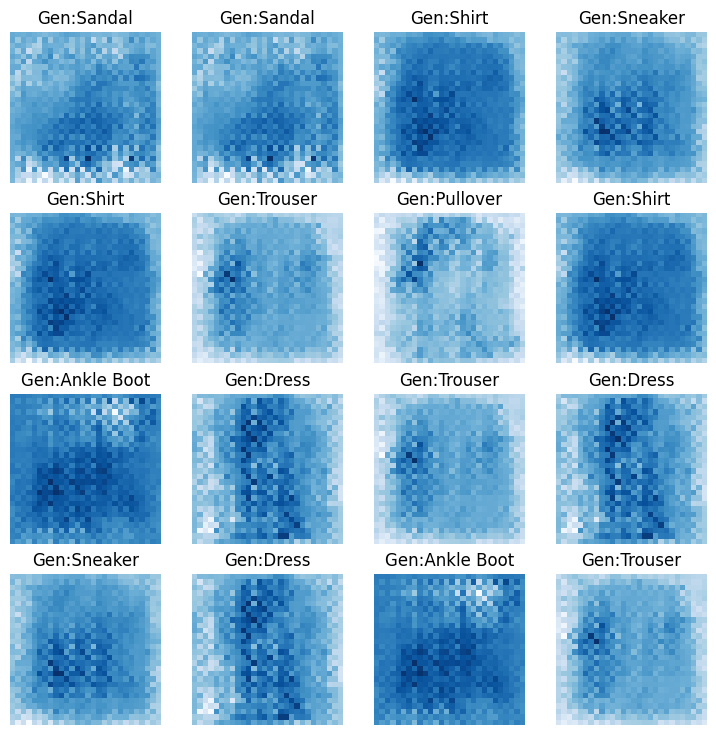

Epoch:2 Iter: 500 ERRD_x: 0.0003 ERRD_z: 0.0010 g_penalty: 6.0998 errG: 0.3747 lr_D: 0.000901411 lr_G: 0.000940077
Epoch:2 Iter: 1000 ERRD_x: 0.0123 ERRD_z: 0.0053 g_penalty: 2.5720 errG: 0.2845 lr_D: 0.000901411 lr_G: 0.000940077
Epoch:2 Iter: 1500 ERRD_x: 0.0254 ERRD_z: 0.0000 g_penalty: 13.3838 errG: 0.4389 lr_D: 0.000896916 lr_G: 0.000939138
Epoch:2 Iter: 2000 ERRD_x: 0.0000 ERRD_z: 0.0028 g_penalty: 2.9083 errG: 0.3929 lr_D: 0.000892442 lr_G: 0.000938199
Epoch:2 Iter: 2500 ERRD_x: 0.0019 ERRD_z: 0.0003 g_penalty: 6.8399 errG: 0.8284 lr_D: 0.000883562 lr_G: 0.000936324
Epoch:2 Iter: 3000 ERRD_x: 0.0011 ERRD_z: 0.0002 g_penalty: 9.3288 errG: 0.5414 lr_D: 0.000874771 lr_G: 0.000934454
Epoch:2 Iter: 3500 ERRD_x: 0.0437 ERRD_z: 0.0000 g_penalty: 7.5992 errG: 0.5518 lr_D: 0.000861747 lr_G: 0.000931654


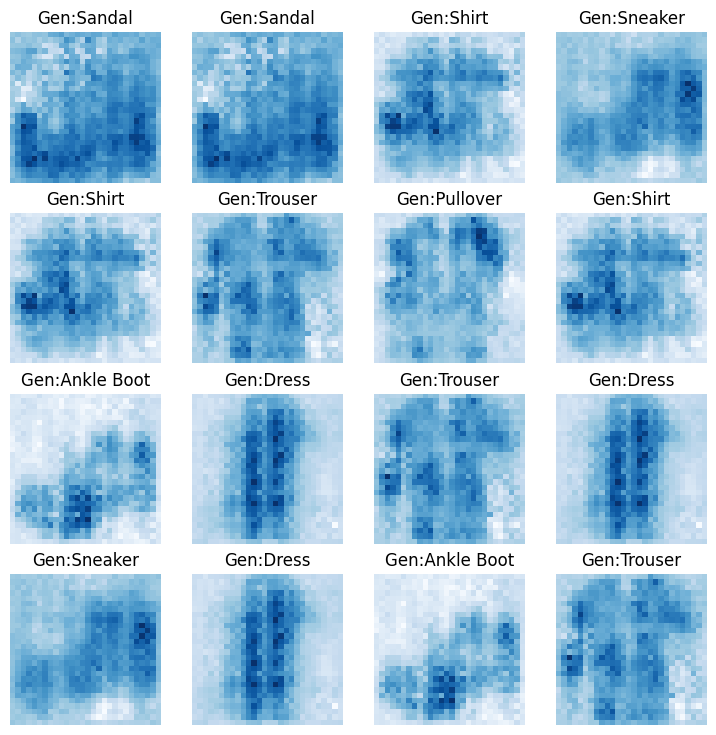

Epoch:3 Iter: 500 ERRD_x: 0.0000 ERRD_z: 0.0000 g_penalty: 8.6871 errG: 0.6443 lr_D: 0.000771915 lr_G: 0.000839558
Epoch:3 Iter: 1000 ERRD_x: 0.0046 ERRD_z: 0.0004 g_penalty: 13.3089 errG: 0.1997 lr_D: 0.000771915 lr_G: 0.000839558
Epoch:3 Iter: 1500 ERRD_x: 0.0030 ERRD_z: 0.0001 g_penalty: 16.9712 errG: 0.5053 lr_D: 0.000768065 lr_G: 0.000838719
Epoch:3 Iter: 2000 ERRD_x: 0.0042 ERRD_z: 0.0203 g_penalty: 3.3396 errG: 0.2489 lr_D: 0.000764235 lr_G: 0.000837880
Epoch:3 Iter: 2500 ERRD_x: 0.0001 ERRD_z: 0.0002 g_penalty: 11.4053 errG: 0.5467 lr_D: 0.000756630 lr_G: 0.000836206
Epoch:3 Iter: 3000 ERRD_x: 0.0048 ERRD_z: 0.0010 g_penalty: 12.8263 errG: 0.6788 lr_D: 0.000749102 lr_G: 0.000834535
Epoch:3 Iter: 3500 ERRD_x: 0.0096 ERRD_z: 0.0002 g_penalty: 11.3957 errG: 0.4413 lr_D: 0.000737949 lr_G: 0.000832036


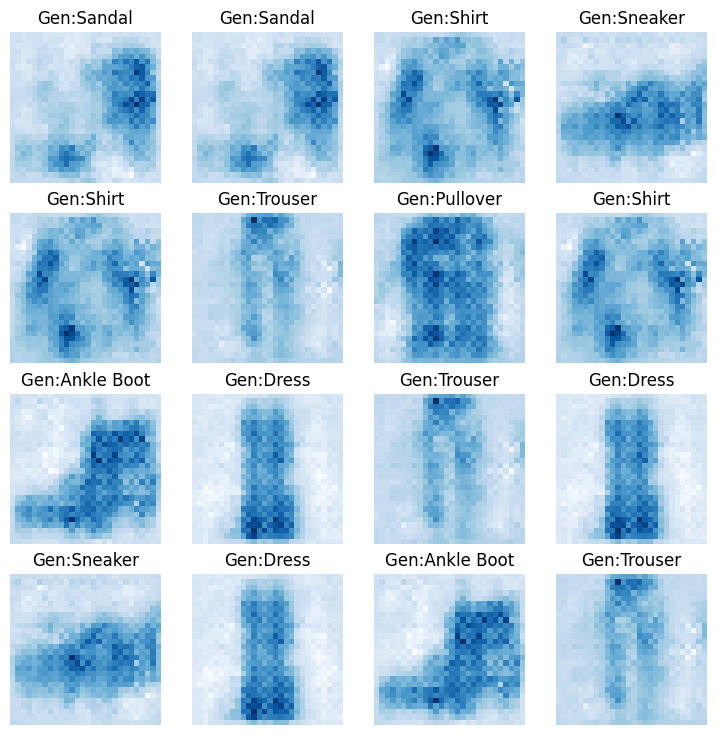

Epoch:4 Iter: 500 ERRD_x: 0.0012 ERRD_z: 0.0002 g_penalty: 27.7876 errG: 0.4157 lr_D: 0.000627971 lr_G: 0.000712297
Epoch:4 Iter: 1000 ERRD_x: 0.0008 ERRD_z: 0.0059 g_penalty: 16.1951 errG: 0.3460 lr_D: 0.000627971 lr_G: 0.000712297
Epoch:4 Iter: 1500 ERRD_x: 0.0052 ERRD_z: 0.0002 g_penalty: 4.4381 errG: 0.4794 lr_D: 0.000624839 lr_G: 0.000711585
Epoch:4 Iter: 2000 ERRD_x: 0.0000 ERRD_z: 0.0030 g_penalty: 9.4100 errG: 0.2374 lr_D: 0.000621723 lr_G: 0.000710874
Epoch:4 Iter: 2500 ERRD_x: 0.0025 ERRD_z: 0.0032 g_penalty: 4.1508 errG: 0.2125 lr_D: 0.000615537 lr_G: 0.000709454
Epoch:4 Iter: 3000 ERRD_x: 0.0000 ERRD_z: 0.0029 g_penalty: 4.5623 errG: 0.2966 lr_D: 0.000609412 lr_G: 0.000708036
Epoch:4 Iter: 3500 ERRD_x: 0.0779 ERRD_z: 0.0010 g_penalty: 10.9499 errG: 0.1589 lr_D: 0.000600339 lr_G: 0.000705915


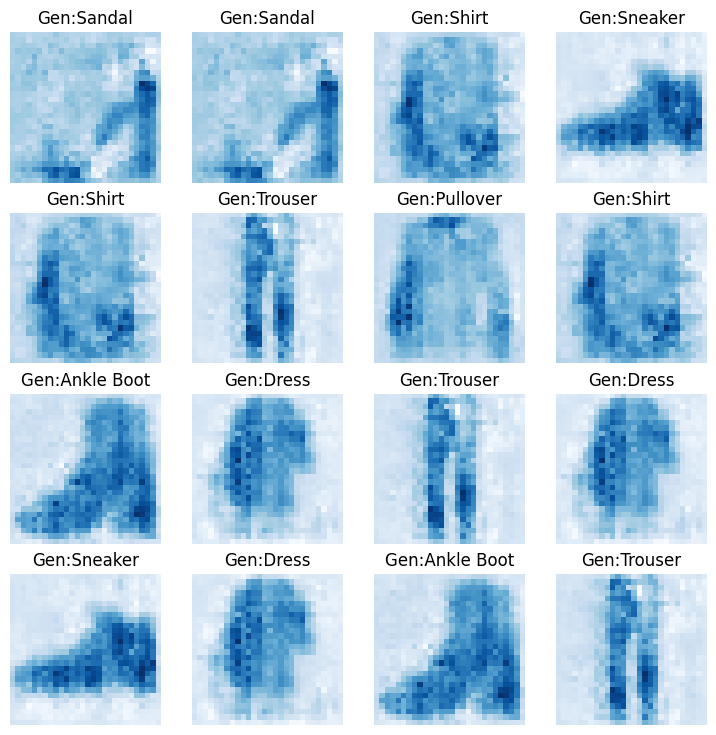

Epoch:5 Iter: 500 ERRD_x: 0.0160 ERRD_z: 0.0029 g_penalty: 11.5223 errG: 0.3585 lr_D: 0.000485326 lr_G: 0.000574111
Epoch:5 Iter: 1000 ERRD_x: 0.0003 ERRD_z: 0.0034 g_penalty: 10.2808 errG: 0.2128 lr_D: 0.000485326 lr_G: 0.000574111
Epoch:5 Iter: 1500 ERRD_x: 0.0066 ERRD_z: 0.0002 g_penalty: 5.1606 errG: 0.4653 lr_D: 0.000482906 lr_G: 0.000573537
Epoch:5 Iter: 2000 ERRD_x: 0.0027 ERRD_z: 0.0003 g_penalty: 8.4060 errG: 0.7268 lr_D: 0.000480497 lr_G: 0.000572964
Epoch:5 Iter: 2500 ERRD_x: 0.0265 ERRD_z: 0.0002 g_penalty: 6.7931 errG: 0.1672 lr_D: 0.000475716 lr_G: 0.000571819
Epoch:5 Iter: 3000 ERRD_x: 0.0008 ERRD_z: 0.0009 g_penalty: 16.5315 errG: 0.3089 lr_D: 0.000470983 lr_G: 0.000570676
Epoch:5 Iter: 3500 ERRD_x: 0.0028 ERRD_z: 0.0004 g_penalty: 12.0953 errG: 0.4041 lr_D: 0.000463971 lr_G: 0.000568967


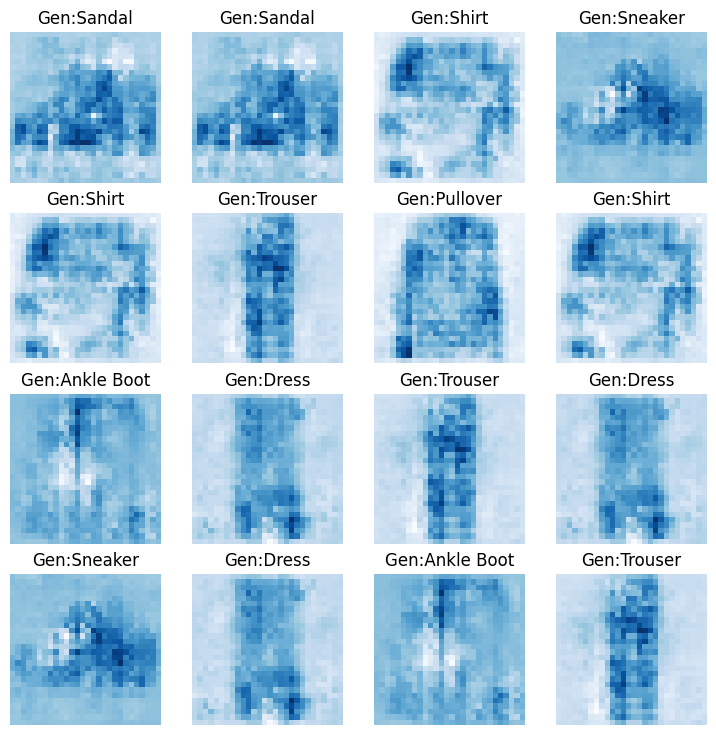

Epoch:6 Iter: 500 ERRD_x: 0.0043 ERRD_z: 0.0082 g_penalty: 16.7297 errG: 0.3083 lr_D: 0.000356329 lr_G: 0.000439596
Epoch:6 Iter: 1000 ERRD_x: 0.0002 ERRD_z: 0.0045 g_penalty: 11.4952 errG: 0.3255 lr_D: 0.000356329 lr_G: 0.000439596
Epoch:6 Iter: 1500 ERRD_x: 0.0020 ERRD_z: 0.0015 g_penalty: 30.4900 errG: 0.3355 lr_D: 0.000354552 lr_G: 0.000439156
Epoch:6 Iter: 2000 ERRD_x: 0.0002 ERRD_z: 0.0008 g_penalty: 18.9990 errG: 0.2586 lr_D: 0.000352783 lr_G: 0.000438717
Epoch:6 Iter: 2500 ERRD_x: 0.0162 ERRD_z: 0.0004 g_penalty: 18.2788 errG: 0.3751 lr_D: 0.000349273 lr_G: 0.000437841
Epoch:6 Iter: 3000 ERRD_x: 0.0054 ERRD_z: 0.0002 g_penalty: 15.1813 errG: 0.3890 lr_D: 0.000345798 lr_G: 0.000436966
Epoch:6 Iter: 3500 ERRD_x: 0.0002 ERRD_z: 0.0013 g_penalty: 25.2824 errG: 0.4218 lr_D: 0.000340650 lr_G: 0.000435657


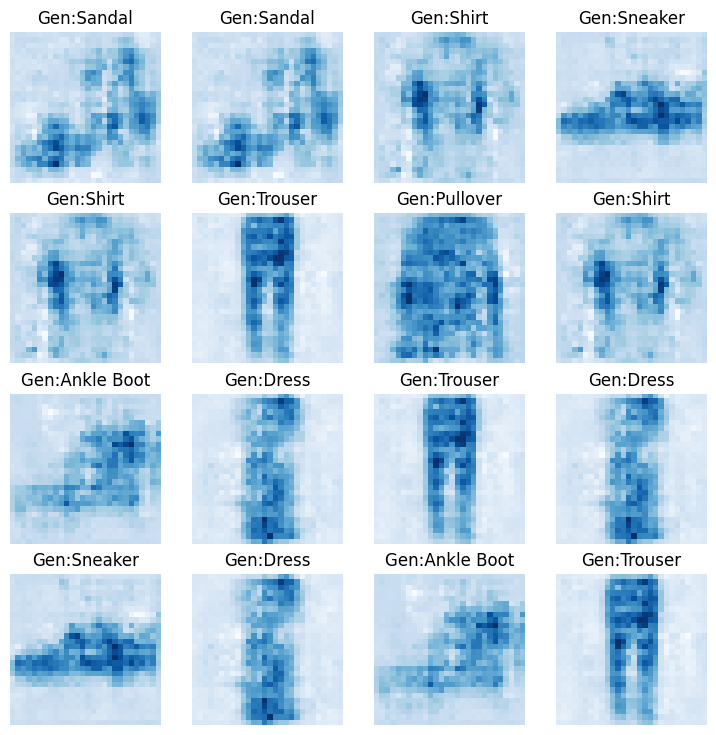

Epoch:7 Iter: 500 ERRD_x: 0.0000 ERRD_z: 0.0043 g_penalty: 35.0876 errG: 0.2294 lr_D: 0.000248538 lr_G: 0.000319768
Epoch:7 Iter: 1000 ERRD_x: 0.0307 ERRD_z: 0.0012 g_penalty: 23.4555 errG: 0.2498 lr_D: 0.000248538 lr_G: 0.000319768
Epoch:7 Iter: 1500 ERRD_x: 0.0002 ERRD_z: 0.0005 g_penalty: 34.0257 errG: 0.3303 lr_D: 0.000247298 lr_G: 0.000319448
Epoch:7 Iter: 2000 ERRD_x: 0.0002 ERRD_z: 0.0010 g_penalty: 24.4468 errG: 0.3481 lr_D: 0.000246065 lr_G: 0.000319129
Epoch:7 Iter: 2500 ERRD_x: 0.0260 ERRD_z: 0.0002 g_penalty: 16.2268 errG: 0.4538 lr_D: 0.000243616 lr_G: 0.000318491
Epoch:7 Iter: 3000 ERRD_x: 0.0392 ERRD_z: 0.0004 g_penalty: 21.7081 errG: 0.4654 lr_D: 0.000241192 lr_G: 0.000317855
Epoch:7 Iter: 3500 ERRD_x: 0.0268 ERRD_z: 0.0036 g_penalty: 59.5591 errG: 0.1537 lr_D: 0.000237601 lr_G: 0.000316903


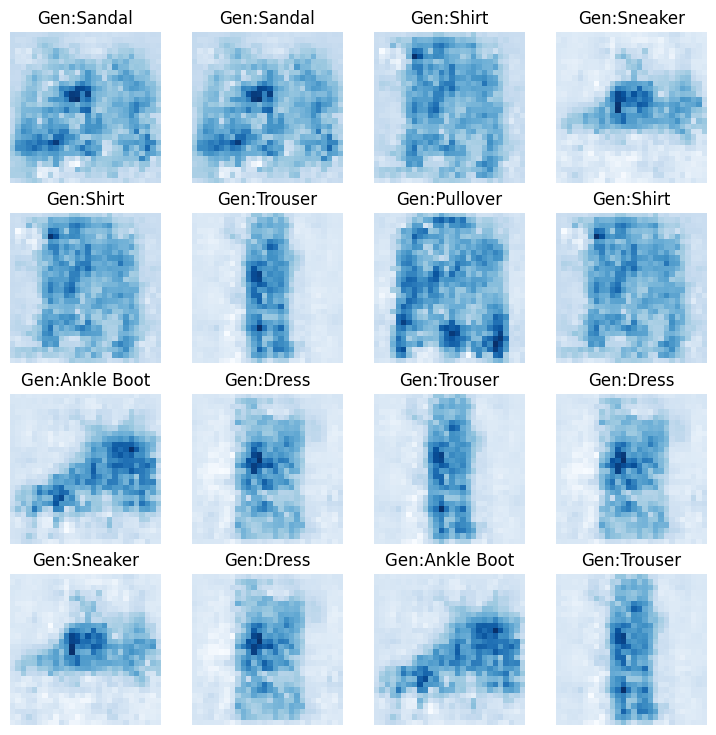

Epoch:8 Iter: 500 ERRD_x: 0.0097 ERRD_z: 0.0028 g_penalty: 34.8341 errG: 0.2577 lr_D: 0.000164686 lr_G: 0.000220973
Epoch:8 Iter: 1000 ERRD_x: 0.0000 ERRD_z: 0.0012 g_penalty: 25.7352 errG: 0.3544 lr_D: 0.000164686 lr_G: 0.000220973
Epoch:8 Iter: 1500 ERRD_x: 0.0002 ERRD_z: 0.0042 g_penalty: 32.8630 errG: 0.3699 lr_D: 0.000163865 lr_G: 0.000220753
Epoch:8 Iter: 2000 ERRD_x: 0.0023 ERRD_z: 0.0006 g_penalty: 32.8422 errG: 0.2692 lr_D: 0.000163047 lr_G: 0.000220532
Epoch:8 Iter: 2500 ERRD_x: 0.0013 ERRD_z: 0.0010 g_penalty: 35.5061 errG: 0.6531 lr_D: 0.000161425 lr_G: 0.000220091
Epoch:8 Iter: 3000 ERRD_x: 0.0077 ERRD_z: 0.0011 g_penalty: 29.8901 errG: 0.5659 lr_D: 0.000159819 lr_G: 0.000219652
Epoch:8 Iter: 3500 ERRD_x: 0.0119 ERRD_z: 0.0007 g_penalty: 31.8808 errG: 0.3359 lr_D: 0.000157439 lr_G: 0.000218994


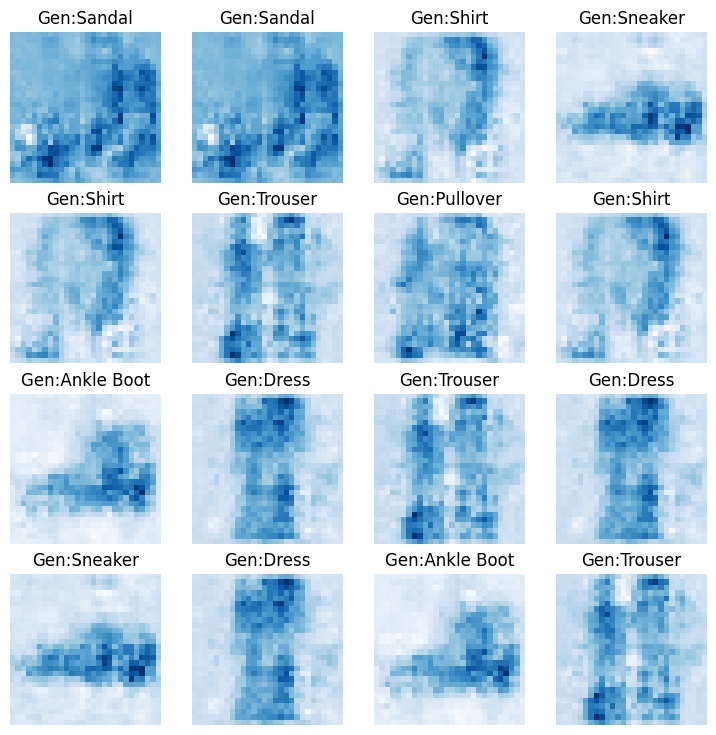

Epoch:9 Iter: 500 ERRD_x: 0.0004 ERRD_z: 0.0017 g_penalty: 18.1967 errG: 0.4802 lr_D: 0.000103668 lr_G: 0.000145067
Epoch:9 Iter: 1000 ERRD_x: 0.0000 ERRD_z: 0.0010 g_penalty: 17.2790 errG: 0.2769 lr_D: 0.000103668 lr_G: 0.000145067
Epoch:9 Iter: 1500 ERRD_x: 0.0040 ERRD_z: 0.0013 g_penalty: 33.3561 errG: 0.2256 lr_D: 0.000103151 lr_G: 0.000144922
Epoch:9 Iter: 2000 ERRD_x: 0.0000 ERRD_z: 0.0010 g_penalty: 29.8507 errG: 0.2623 lr_D: 0.000102637 lr_G: 0.000144777
Epoch:9 Iter: 2500 ERRD_x: 0.0000 ERRD_z: 0.0016 g_penalty: 22.7877 errG: 0.2647 lr_D: 0.000101615 lr_G: 0.000144488
Epoch:9 Iter: 3000 ERRD_x: 0.0007 ERRD_z: 0.0007 g_penalty: 22.2695 errG: 0.2875 lr_D: 0.000100604 lr_G: 0.000144199
Epoch:9 Iter: 3500 ERRD_x: 0.0160 ERRD_z: 0.0013 g_penalty: 48.5262 errG: 0.2215 lr_D: 0.000099106 lr_G: 0.000143767


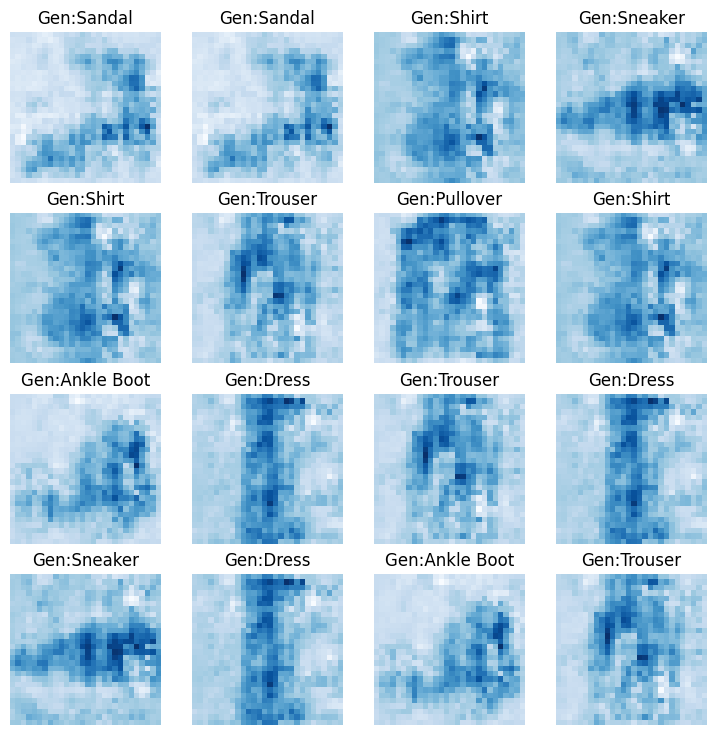

Epoch:10 Iter: 500 ERRD_x: 0.0001 ERRD_z: 0.0011 g_penalty: 30.3854 errG: 0.2616 lr_D: 0.000061995 lr_G: 0.000090473
Epoch:10 Iter: 1000 ERRD_x: 0.0498 ERRD_z: 0.0013 g_penalty: 41.7674 errG: 0.3015 lr_D: 0.000061995 lr_G: 0.000090473
Epoch:10 Iter: 1500 ERRD_x: 0.0000 ERRD_z: 0.0009 g_penalty: 49.6382 errG: 0.2835 lr_D: 0.000061686 lr_G: 0.000090383
Epoch:10 Iter: 2000 ERRD_x: 0.0000 ERRD_z: 0.0018 g_penalty: 44.4761 errG: 0.2223 lr_D: 0.000061378 lr_G: 0.000090293
Epoch:10 Iter: 2500 ERRD_x: 0.0089 ERRD_z: 0.0010 g_penalty: 36.3197 errG: 0.2779 lr_D: 0.000060767 lr_G: 0.000090112
Epoch:10 Iter: 3000 ERRD_x: 0.0000 ERRD_z: 0.0018 g_penalty: 26.3476 errG: 0.2744 lr_D: 0.000060163 lr_G: 0.000089932
Epoch:10 Iter: 3500 ERRD_x: 0.0000 ERRD_z: 0.0014 g_penalty: 25.6716 errG: 0.2617 lr_D: 0.000059267 lr_G: 0.000089663


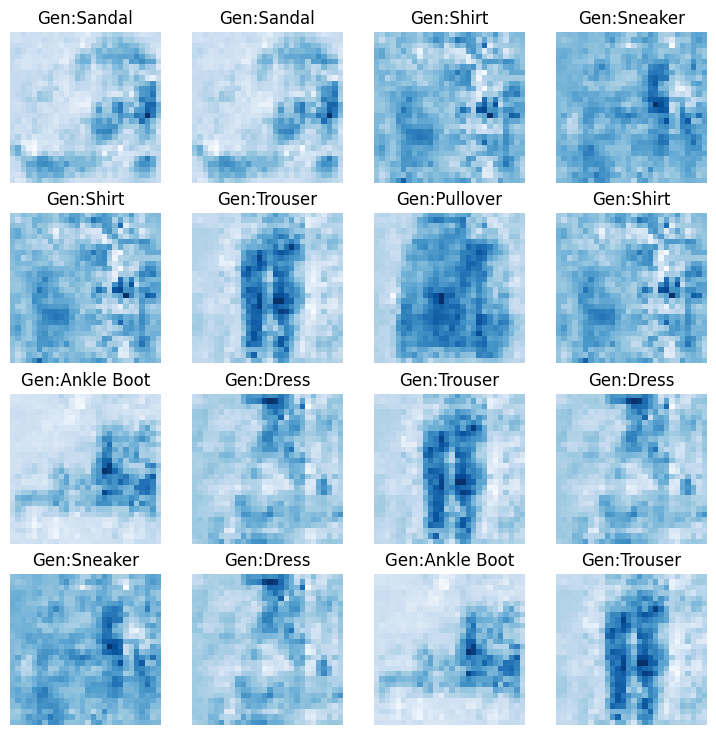

Epoch:11 Iter: 500 ERRD_x: 0.0000 ERRD_z: 0.0014 g_penalty: 31.8203 errG: 0.2427 lr_D: 0.000035220 lr_G: 0.000053604
Epoch:11 Iter: 1000 ERRD_x: 0.0001 ERRD_z: 0.0012 g_penalty: 11.8302 errG: 0.2505 lr_D: 0.000035220 lr_G: 0.000053604
Epoch:11 Iter: 1500 ERRD_x: 0.0001 ERRD_z: 0.0013 g_penalty: 29.0345 errG: 0.2679 lr_D: 0.000035045 lr_G: 0.000053550
Epoch:11 Iter: 2000 ERRD_x: 0.0000 ERRD_z: 0.0010 g_penalty: 30.0341 errG: 0.2614 lr_D: 0.000034870 lr_G: 0.000053497
Epoch:11 Iter: 2500 ERRD_x: 0.0085 ERRD_z: 0.0016 g_penalty: 30.1528 errG: 0.2263 lr_D: 0.000034523 lr_G: 0.000053390
Epoch:11 Iter: 3000 ERRD_x: 0.0000 ERRD_z: 0.0015 g_penalty: 27.7952 errG: 0.2628 lr_D: 0.000034179 lr_G: 0.000053283
Epoch:11 Iter: 3500 ERRD_x: 0.0018 ERRD_z: 0.0014 g_penalty: 14.2136 errG: 0.3090 lr_D: 0.000033670 lr_G: 0.000053124


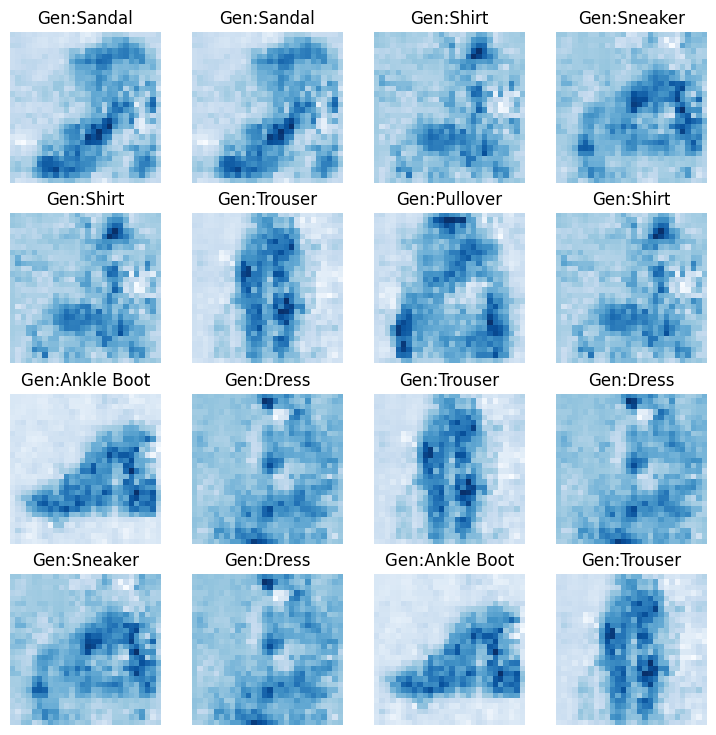

Epoch:12 Iter: 500 ERRD_x: 0.0000 ERRD_z: 0.0019 g_penalty: 37.0184 errG: 0.2213 lr_D: 0.000019009 lr_G: 0.000030171
Epoch:12 Iter: 1000 ERRD_x: 0.0001 ERRD_z: 0.0017 g_penalty: 33.9267 errG: 0.2227 lr_D: 0.000019009 lr_G: 0.000030171
Epoch:12 Iter: 1500 ERRD_x: 0.0067 ERRD_z: 0.0014 g_penalty: 24.4888 errG: 0.2241 lr_D: 0.000018914 lr_G: 0.000030141
Epoch:12 Iter: 2000 ERRD_x: 0.0003 ERRD_z: 0.0012 g_penalty: 32.4694 errG: 0.2308 lr_D: 0.000018820 lr_G: 0.000030111
Epoch:12 Iter: 2500 ERRD_x: 0.0005 ERRD_z: 0.0023 g_penalty: 29.5425 errG: 0.2439 lr_D: 0.000018632 lr_G: 0.000030051
Epoch:12 Iter: 3000 ERRD_x: 0.0000 ERRD_z: 0.0024 g_penalty: 23.0082 errG: 0.2084 lr_D: 0.000018447 lr_G: 0.000029991
Epoch:12 Iter: 3500 ERRD_x: 0.0111 ERRD_z: 0.0014 g_penalty: 26.0016 errG: 0.2605 lr_D: 0.000018172 lr_G: 0.000029901


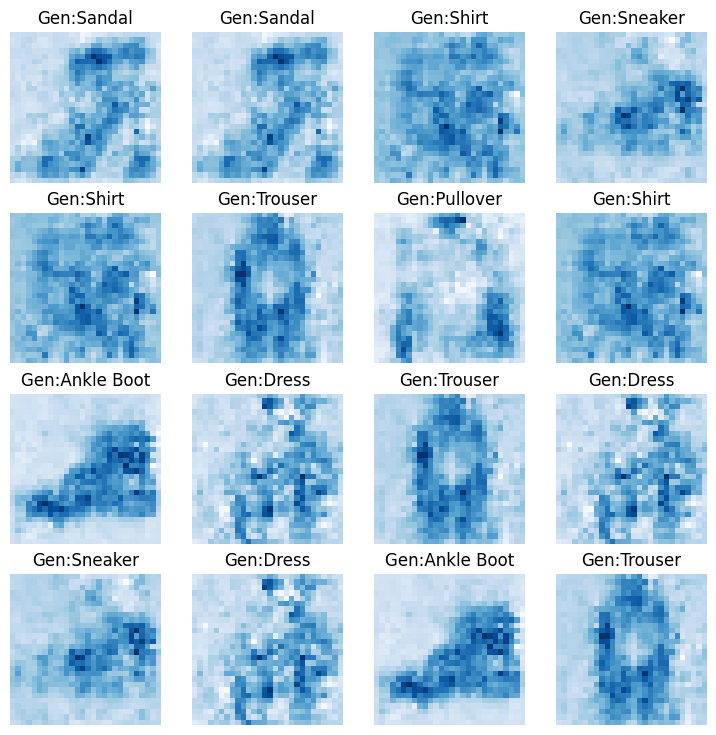

Epoch:13 Iter: 500 ERRD_x: 0.0467 ERRD_z: 0.0017 g_penalty: 20.9640 errG: 0.2385 lr_D: 0.000009746 lr_G: 0.000016133
Epoch:13 Iter: 1000 ERRD_x: 0.0001 ERRD_z: 0.0018 g_penalty: 34.9660 errG: 0.2244 lr_D: 0.000009746 lr_G: 0.000016133
Epoch:13 Iter: 1500 ERRD_x: 0.0000 ERRD_z: 0.0020 g_penalty: 26.6648 errG: 0.2192 lr_D: 0.000009698 lr_G: 0.000016117
Epoch:13 Iter: 2000 ERRD_x: 0.0000 ERRD_z: 0.0021 g_penalty: 34.3606 errG: 0.2110 lr_D: 0.000009649 lr_G: 0.000016101
Epoch:13 Iter: 2500 ERRD_x: 0.0112 ERRD_z: 0.0017 g_penalty: 27.5836 errG: 0.2267 lr_D: 0.000009553 lr_G: 0.000016069
Epoch:13 Iter: 3000 ERRD_x: 0.0241 ERRD_z: 0.0022 g_penalty: 24.3572 errG: 0.2033 lr_D: 0.000009458 lr_G: 0.000016037
Epoch:13 Iter: 3500 ERRD_x: 0.0001 ERRD_z: 0.0022 g_penalty: 31.3983 errG: 0.1972 lr_D: 0.000009317 lr_G: 0.000015989


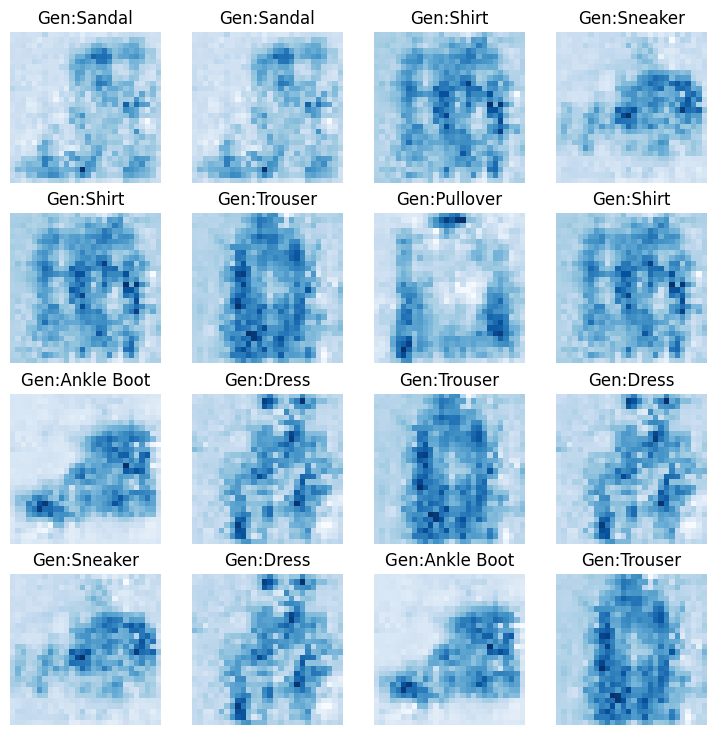

Epoch:14 Iter: 500 ERRD_x: 0.0022 ERRD_z: 0.0029 g_penalty: 31.1127 errG: 0.1931 lr_D: 0.000004747 lr_G: 0.000008195
Epoch:14 Iter: 1000 ERRD_x: 0.0037 ERRD_z: 0.0026 g_penalty: 17.6427 errG: 0.2093 lr_D: 0.000004747 lr_G: 0.000008195
Epoch:14 Iter: 1500 ERRD_x: 0.0003 ERRD_z: 0.0027 g_penalty: 18.4102 errG: 0.2120 lr_D: 0.000004724 lr_G: 0.000008187
Epoch:14 Iter: 2000 ERRD_x: 0.0061 ERRD_z: 0.0031 g_penalty: 29.8238 errG: 0.1989 lr_D: 0.000004700 lr_G: 0.000008179
Epoch:14 Iter: 2500 ERRD_x: 0.0000 ERRD_z: 0.0023 g_penalty: 24.3455 errG: 0.2010 lr_D: 0.000004653 lr_G: 0.000008163
Epoch:14 Iter: 3000 ERRD_x: 0.0123 ERRD_z: 0.0022 g_penalty: 38.7182 errG: 0.2036 lr_D: 0.000004607 lr_G: 0.000008146
Epoch:14 Iter: 3500 ERRD_x: 0.0024 ERRD_z: 0.0030 g_penalty: 32.4055 errG: 0.2027 lr_D: 0.000004538 lr_G: 0.000008122


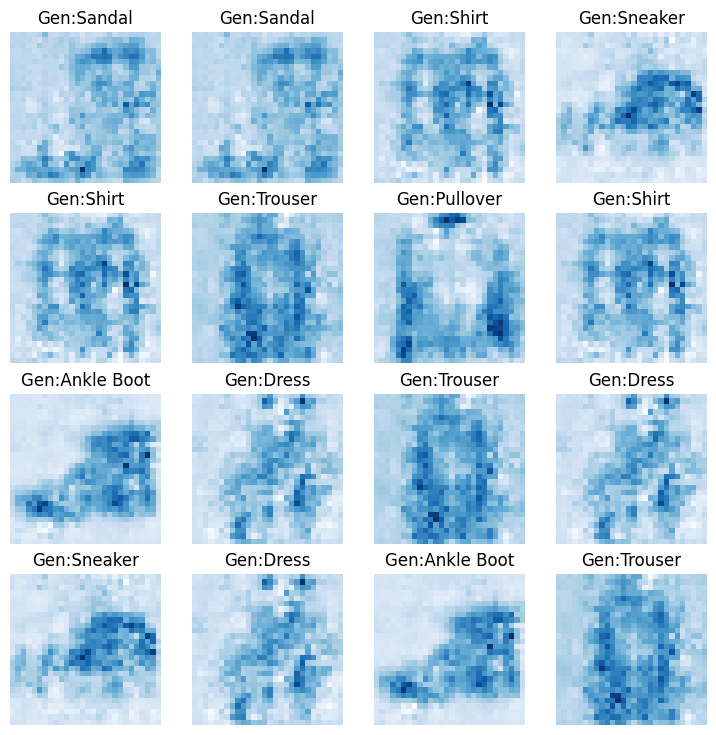

Epoch:15 Iter: 500 ERRD_x: 0.0115 ERRD_z: 0.0019 g_penalty: 26.4942 errG: 0.2067 lr_D: 0.000002197 lr_G: 0.000003955
Epoch:15 Iter: 1000 ERRD_x: 0.0087 ERRD_z: 0.0026 g_penalty: 23.8937 errG: 0.2065 lr_D: 0.000002197 lr_G: 0.000003955
Epoch:15 Iter: 1500 ERRD_x: 0.0000 ERRD_z: 0.0021 g_penalty: 24.2510 errG: 0.2303 lr_D: 0.000002186 lr_G: 0.000003951
Epoch:15 Iter: 2000 ERRD_x: 0.0060 ERRD_z: 0.0025 g_penalty: 21.5411 errG: 0.2111 lr_D: 0.000002175 lr_G: 0.000003947
Epoch:15 Iter: 2500 ERRD_x: 0.0006 ERRD_z: 0.0021 g_penalty: 30.6983 errG: 0.2141 lr_D: 0.000002153 lr_G: 0.000003939
Epoch:15 Iter: 3000 ERRD_x: 0.0000 ERRD_z: 0.0023 g_penalty: 19.5784 errG: 0.2083 lr_D: 0.000002132 lr_G: 0.000003931
Epoch:15 Iter: 3500 ERRD_x: 0.0003 ERRD_z: 0.0023 g_penalty: 26.4768 errG: 0.2044 lr_D: 0.000002100 lr_G: 0.000003919


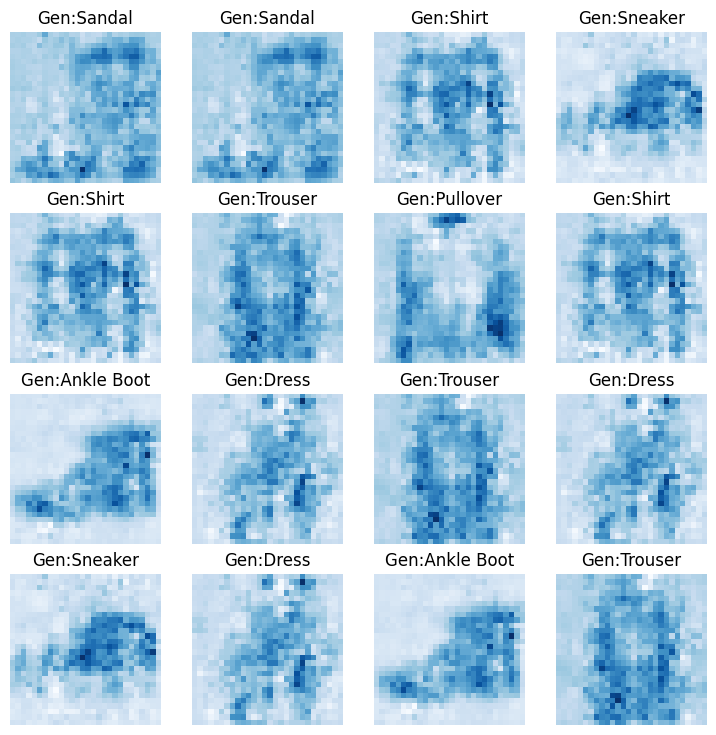

In [ ]:
ERRD_x = np.zeros(config.num_epochs)
ERRD_z = np.zeros(config.num_epochs)
ERRD_p = np.zeros(config.num_epochs)
ERR_G = np.zeros(config.num_epochs)
N = len(dataloader)

# Loss weight for gradient penalty
lambda_gp = 1

for epoch in range(config.num_epochs):

    optim_D.param_groups[0]['lr'] *=  0.95**epoch
    optim_G.param_groups[0]['lr'] *=  0.95**epoch

    for iteration, (images, cat) in enumerate(dataloader):
        optim_D.param_groups[0]['lr'] *=  0.99999**(iteration//1000)


        #######
        # Discriminator stage: maximize log(D(x)) + log(1 - D(G(z)))
        #######

        discriminator.zero_grad()

        cls_images =  cat.to(DEVICE)

        # real
        label.data.fill_(real_label)
        input_data = images.to(DEVICE)
        output = discriminator(input_data.view(gen_images.shape[0], -1), cls_images).view(-1)
        errD_x = criterion(output, label)
        errD_x = errD_x/config.batch_size
        ERRD_x[epoch] += errD_x.item()
        errD_x.backward()

        # fake
        #noise.data.normal_(0, 1)
        noise = torch.concat([torch.randn(1, 1, IMG_ROWS, IMG_COLS) for _ in range(config.batch_size)], axis = 0)
        noise = Variable(noise).to(DEVICE)
        fake = generator(noise, cls_images)
        label.data.fill_(fake_label)
        output = discriminator(fake.detach().view(gen_images.shape[0], -1), cls_images).view(-1)
        errD_z = criterion(output, label)
        errD_z = errD_z/config.batch_size
        ERRD_z[epoch] += errD_z.item()

        errD_z.backward()
        optim_D.step()


        # Gradient penalty
        gradient_penalty = lambda_gp * compute_gradient_penalty(discriminator,
                                                                input_data,
                                                                fake,
                                                                cls_images
                                                                )
        gradient_penalty = gradient_penalty/config.batch_size
        ERRD_p[epoch] += gradient_penalty.item()

        gradient_penalty.backward(retain_graph=True)



        #######
        # Generator stage: maximize log(D(G(x))
        #######

        # Train the generator every n_critic steps
        if iteration % config.n_critic == 0:

            optim_G.param_groups[0]['lr'] *=  0.99999**(iteration//1000)
            generator.zero_grad()

            label.data.fill_(real_label)
            output = discriminator(fake.view(gen_images.shape[0], -1), cls_images).view(-1)
            errG = criterion(output, label)
            errG = errG/config.batch_size
            ERR_G[epoch] += errG.item()

            errG.backward()
            optim_G.step()

        if (iteration+1) % config.print_freq == 0:  #
            print('Epoch:{} Iter: {} ERRD_x: {:.4f} ERRD_z: {:.4f} g_penalty: {:.4f} errG: {:.4f} lr_D: {:.9f} lr_G: {:.9f}'.format(epoch+1,
                                iteration+1,
                                errD_x.item(),
                                errD_z.item(),
                                gradient_penalty.item(),
                                errG.item(),
                                optim_D.param_groups[0]['lr'],
                                optim_G.param_groups[0]['lr']
                                )
            )


        # Show result with fix_noise
        gen_images = generator(fixed_noise, fixed_classes.to(DEVICE))
        if iteration == N-1: plot_gen_images(gen_images, fixed_classes)

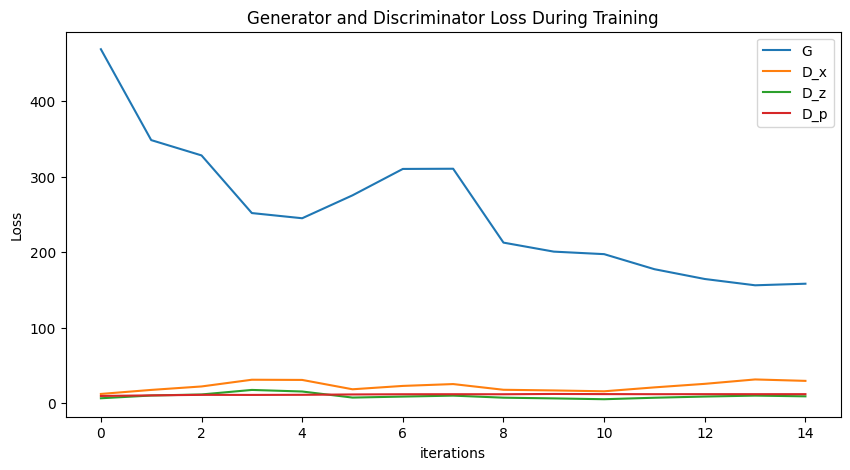

In [ ]:
plt.figure(figsize=(10,5))
plt.title("Generator and Discriminator Loss During Training")
plt.plot(ERR_G,label="G")
plt.plot(ERRD_x,label="D_x")
plt.plot(ERRD_z,label="D_z")
plt.plot(np.log(ERRD_p),label="D_p")
plt.xlabel("iterations")
plt.ylabel("Loss")
plt.legend()
plt.show()

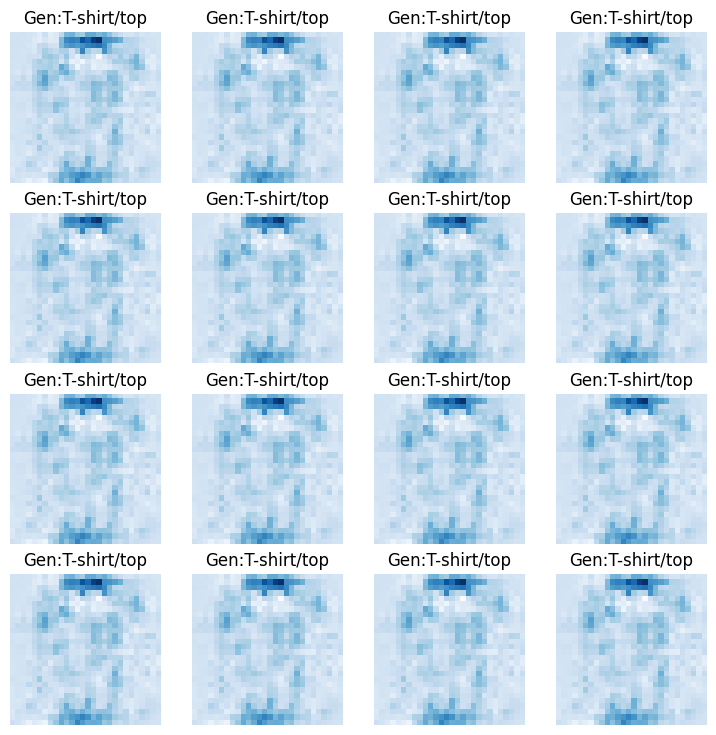

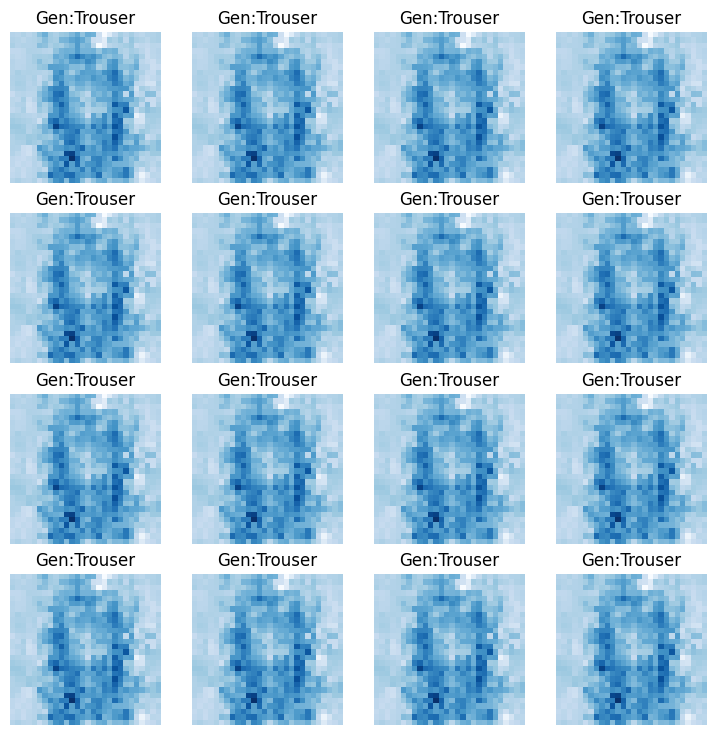

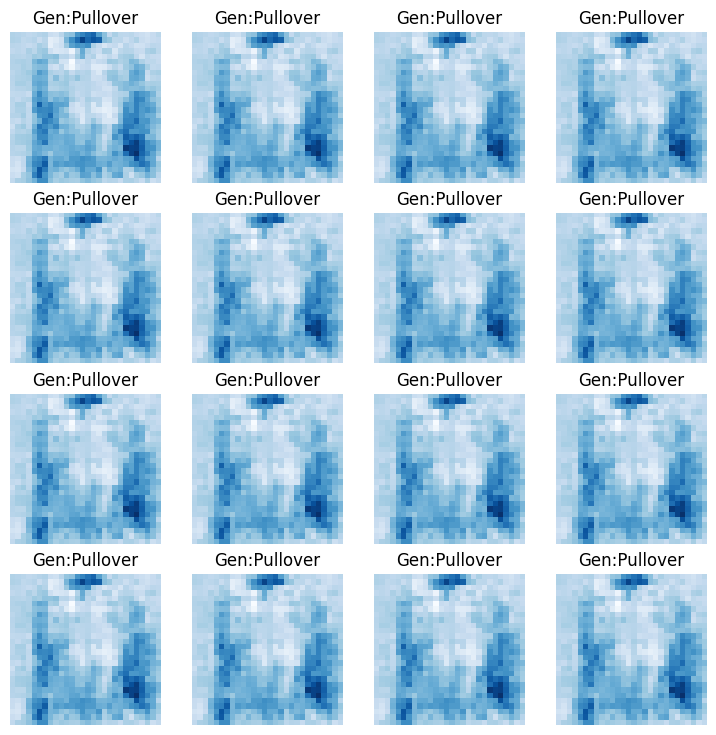

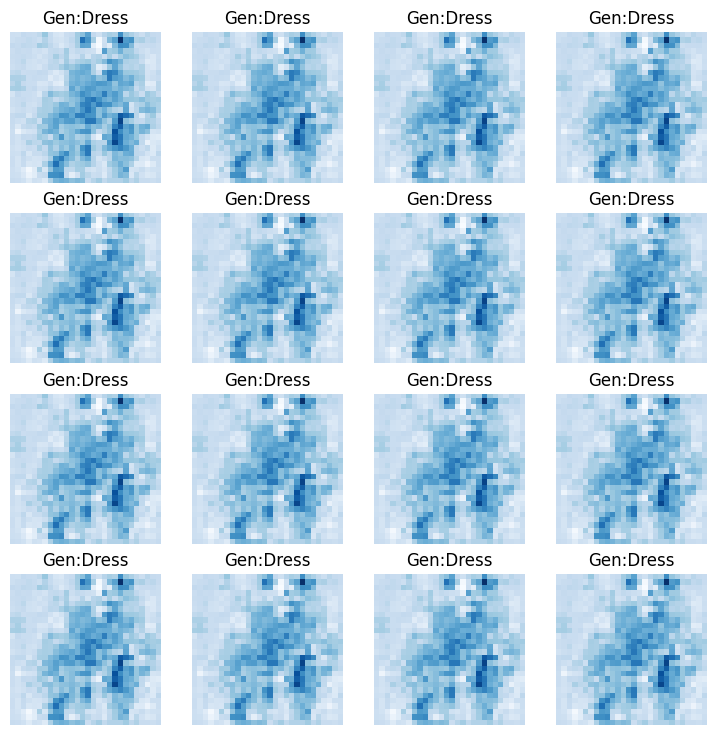

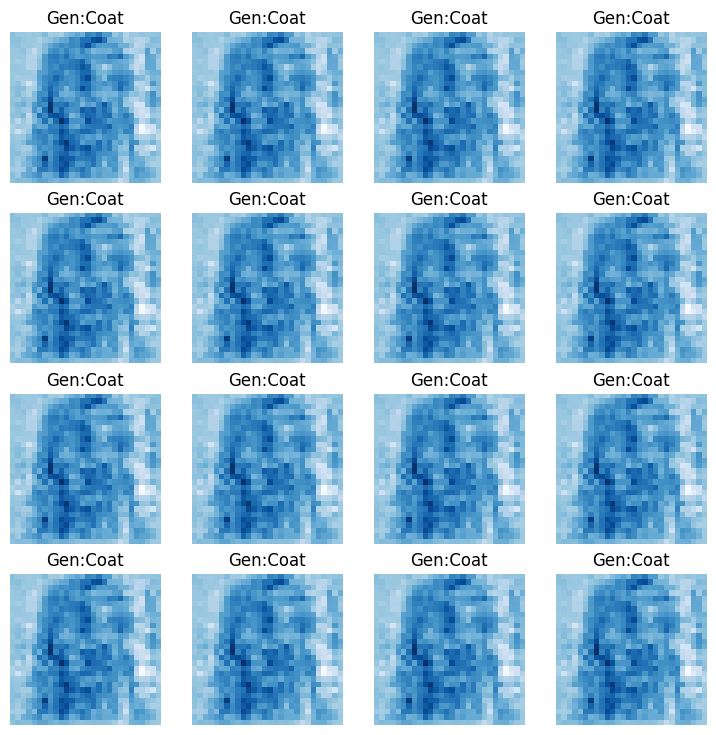

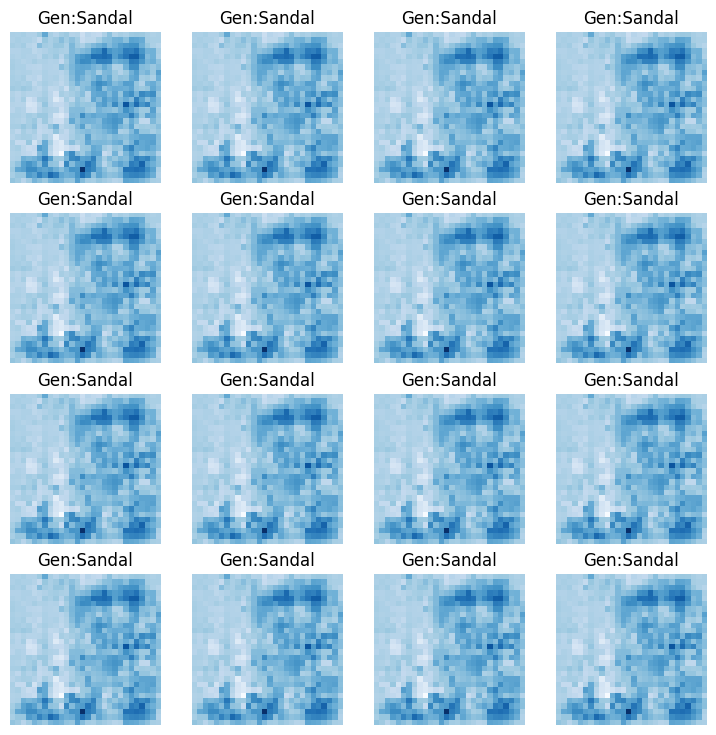

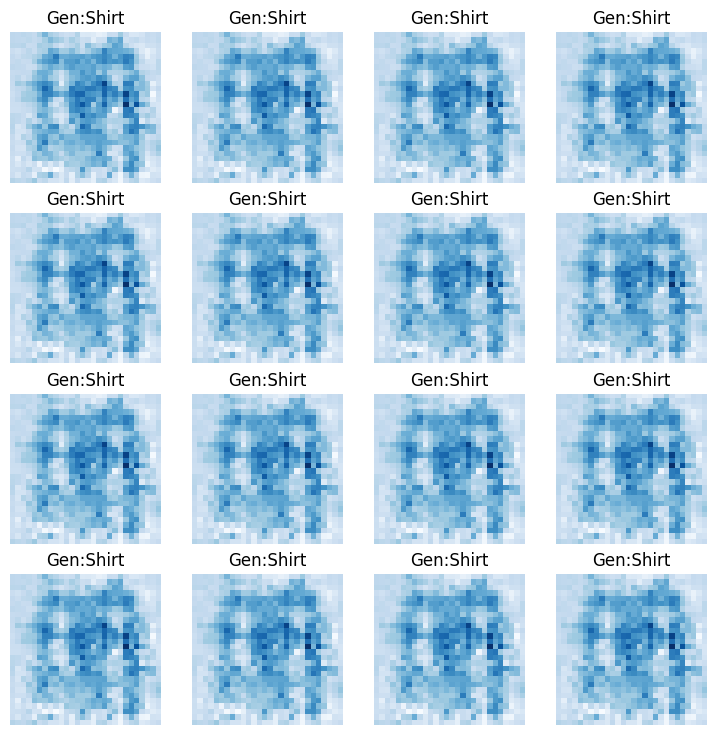

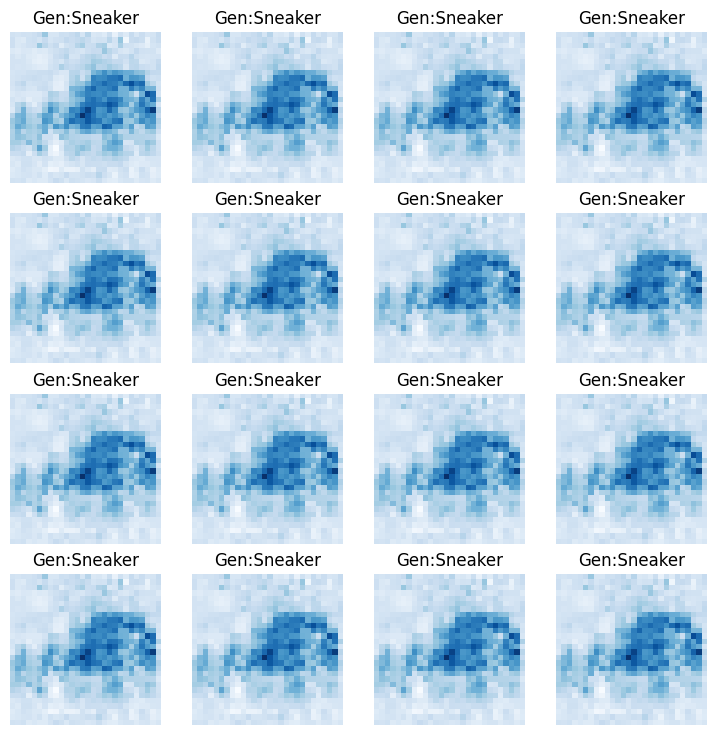

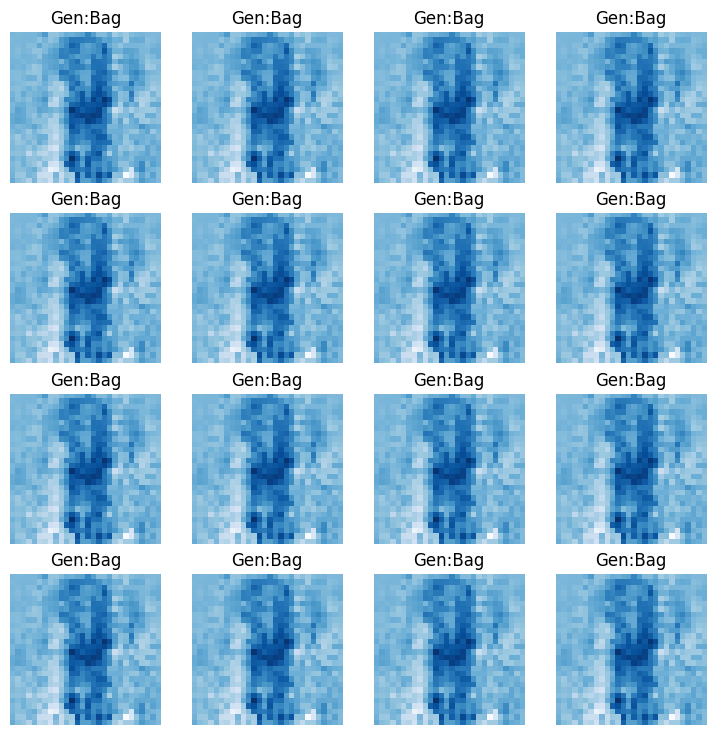

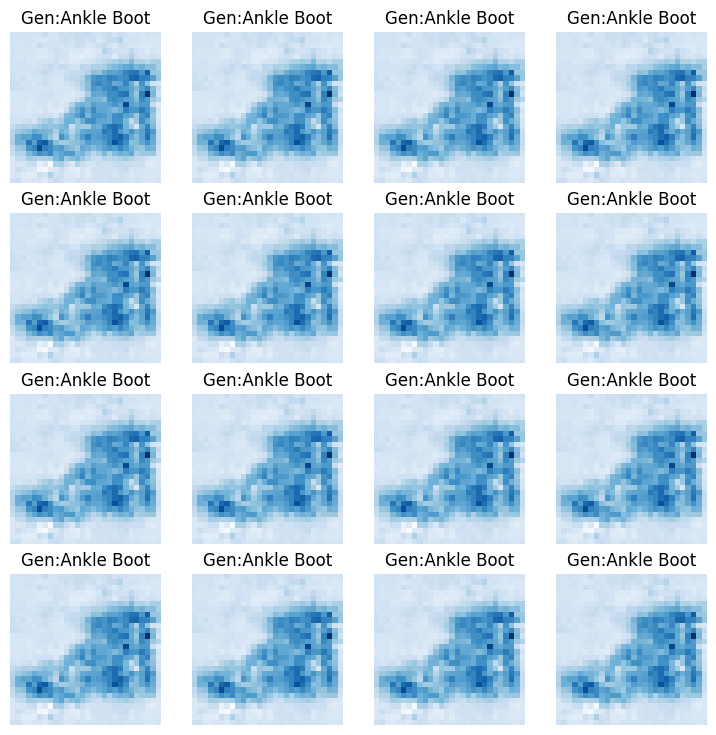

In [ ]:
noise = torch.concat([torch.randn(1, 1, IMG_ROWS, IMG_COLS) for _ in range(16)], axis = 0)
noise = Variable(noise).to(DEVICE)

for cls in range(10):
  gen_images = generator(noise, cls*torch.ones((16), dtype=torch.int).to(DEVICE))
  plot_gen_images(gen_images, cls*torch.ones((16), dtype=torch.int))
  print()

# Комментарий

- Построен генератор на основе Conv автоэнкодера

- Условная генерация работает, стало появляться разнообразие в генерации.

- Добавлено изменение шага обучения

- Разделено обучение генератора и критика(дискриминатора), и шаг у них тоже разный

- Появились Сандали уже


